# Expedia Hotel Recommendations

#### Which hotel type will an Expedia customer book?

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            919        642  0.9375           
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1001        592  0.875            
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022

In [5]:
!kaggle competitions download -c expedia-hotel-recommendations
! mkdir train

100% 684M/686M [00:08<00:00, 105MB/s] 
100% 686M/686M [00:08<00:00, 81.3MB/s]


In [6]:
! unzip expedia-hotel-recommendations.zip -d train

Archive:  expedia-hotel-recommendations.zip
  inflating: train/destinations.csv  
  inflating: train/sample_submission.csv  
  inflating: train/test.csv          
  inflating: train/train.csv         


In [ ]:
# df_raw = pd.read_csv('train/train.csv')
# print(df_raw.shape)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
!pip install deepctr

     |████████████████████████████████| 147 kB 4.8 MB/s 
     |████████████████████████████████| 2.9 MB 36.0 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [11]:
%tensorflow_version 1.15.0
import tensorflow as tf
import math
import sys
import holidays
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from math import sqrt


from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense

# from deepctr.inputs import build_input_features, get_linear_logit, input_from_feature_columns, combined_dnn_input
from deepctr.inputs import get_inputs_list, get_dense_input
from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func
from deepctr.models import DeepFM

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


### Reading training data (train.csv)

In [12]:
train_data = pd.read_csv('train/train.csv', sep = ",", nrows = 100000)
# train_data = pd.read_csv("train.csv", sep = ",")

### Getting familiar with the data and Exploratory Data Analysis

In [13]:
train_data.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [14]:
train_data.shape

(100000, 24)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  63078 non-null   float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    99929 non-null   object 
 12  srch_co                    99929 non-null   object 
 13  srch_adults_cnt            100

In [16]:
train_data.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,63078.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,9.10014,2.637850,84.531040,311.630930,28465.223540,1897.609161,195700.878390,0.138030,0.260470,5.760540,...,0.325160,1.112700,14511.034340,2.590540,0.08270,1.477770,3.206530,80.972620,597.559610,49.74576
std,12.09091,0.751001,54.320574,209.399151,16822.922817,2123.885180,110173.879786,0.344933,0.438893,3.771156,...,0.722341,0.441928,11043.082364,2.160456,0.27543,1.197163,1.624119,55.679861,507.624672,28.95063
min,2.00000,0.000000,0.000000,0.000000,3.000000,0.005600,12.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,2.00000,3.000000,66.000000,174.000000,13914.000000,290.528875,107548.000000,0.000000,0.000000,2.000000,...,0.000000,1.000000,8267.000000,1.000000,0.00000,1.000000,2.000000,50.000000,160.000000,25.00000
50%,2.00000,3.000000,66.000000,311.000000,27733.000000,1093.888450,181983.000000,0.000000,0.000000,9.000000,...,0.000000,1.000000,11271.000000,1.000000,0.00000,1.000000,2.000000,50.000000,585.000000,49.00000
75%,11.00000,3.000000,69.000000,385.000000,43113.000000,2518.177400,301357.000000,0.000000,1.000000,9.000000,...,0.000000,1.000000,18881.000000,5.000000,0.00000,2.000000,4.000000,106.000000,701.000000,73.00000
max,53.00000,4.000000,239.000000,1025.000000,56495.000000,11641.224200,391007.000000,1.000000,1.000000,10.000000,...,9.000000,8.000000,65035.000000,9.000000,1.00000,59.000000,6.000000,212.000000,2117.000000,99.00000


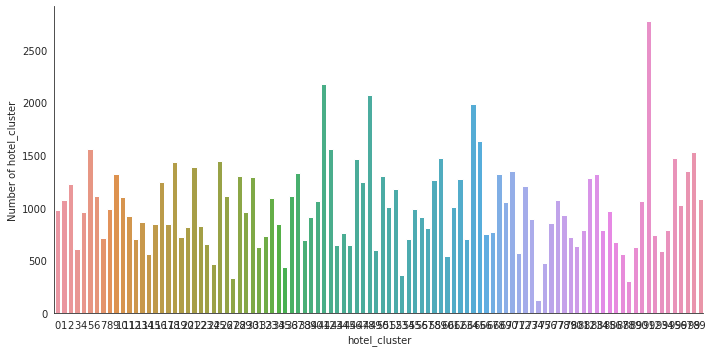

In [17]:
with sns.axes_style('white'):
    g = sns.factorplot("hotel_cluster", data=train_data, aspect=2.0,kind='count')
    g.set_ylabels("Number of hotel_cluster")

## Importing Destination data

In [18]:
destination_data = pd.read_csv("train/destinations.csv", sep=',')

In [19]:
destination_data.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


### Applying PCA to get 10 most relevant dimensions

In [20]:
model = PCA(n_components=None).fit(destination_data)
destination_data_pc = model.transform(destination_data)
destination_data_pc

array([[-3.23594639e+04,  3.91171508e-02,  1.83897680e-01, ...,
        -8.95076187e-04,  2.72242521e-05, -1.38904284e-06],
       [-3.23584639e+04, -3.56569311e-01,  9.17178951e-02, ...,
         1.90740877e-04, -2.29089126e-04,  8.45786956e-05],
       [-3.23574639e+04,  8.63287331e-02,  3.66722352e-02, ...,
        -2.13700576e-03,  1.87017759e-03, -2.20432977e-04],
       ...,
       [ 3.26315361e+04,  8.05617083e-02,  1.92824073e-01, ...,
        -5.68538143e-04, -1.21487882e-04,  1.58066944e-04],
       [ 3.26325361e+04, -6.66110376e-01, -4.38087800e-02, ...,
        -4.00914640e-05,  2.20538540e-04, -1.60722688e-05],
       [ 3.26335361e+04, -4.61482798e-01, -2.75790500e-02, ...,
        -4.96164892e-04, -1.61638319e-04,  3.60342984e-05]])

In [21]:
number_features= model.components_.shape[0]
number_features

150

### Most important feature index on each component

In [22]:
most_related_column = [np.abs(model.components_[i]).argmax() for i in range(number_features)]
print(most_related_column)

[0, 37, 9, 58, 108, 6, 108, 20, 108, 88, 6, 20, 71, 94, 71, 53, 6, 66, 53, 43, 136, 103, 103, 53, 14, 77, 136, 141, 114, 132, 55, 136, 55, 44, 13, 44, 122, 122, 11, 110, 11, 83, 76, 21, 17, 78, 146, 17, 129, 137, 126, 126, 75, 126, 129, 34, 34, 10, 142, 47, 47, 22, 102, 2, 25, 96, 35, 4, 35, 36, 61, 61, 30, 73, 36, 1, 109, 96, 127, 50, 1, 98, 127, 134, 30, 82, 48, 32, 69, 81, 105, 81, 81, 85, 59, 68, 32, 8, 38, 143, 42, 62, 39, 62, 54, 144, 124, 26, 104, 67, 89, 120, 125, 107, 100, 46, 19, 3, 145, 133, 63, 64, 63, 28, 95, 111, 95, 148, 117, 97, 52, 31, 40, 118, 12, 140, 86, 119, 86, 60, 90, 113, 70, 15, 23, 116, 123, 72, 72, 135]


In [23]:
initial_column= ['srch_destination_id', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40', 'd41', 'd42', 'd43', 'd44', 'd45', 'd46', 'd47', 'd48', 'd49', 'd50', 'd51', 'd52', 'd53', 'd54', 'd55', 'd56', 'd57', 'd58', 'd59', 'd60', 'd61', 'd62', 'd63', 'd64', 'd65', 'd66', 'd67', 'd68', 'd69', 'd70', 'd71', 'd72', 'd73', 'd74', 'd75', 'd76', 'd77', 'd78', 'd79', 'd80', 'd81', 'd82', 'd83', 'd84', 'd85', 'd86', 'd87', 'd88', 'd89', 'd90', 'd91', 'd92', 'd93', 'd94', 'd95', 'd96', 'd97', 'd98', 'd99','d100','d101','d102','d103','d104','d105','d106', 'd107','d108','d109','d110','d111','d112','d113','d114','d115', 'd116','d117','d118','d119','d120','d121','d122','d123','d124','d125','d126','d127','d128','d129','d130','d131','d132','d133','d134','d135','d136','d137','d138','d139','d140','d141','d142','d143', 'd144','d145','d146','d147','d148','d149']

### Get the names of most important features

In [24]:
most_relevant_column_names = [initial_column[most_related_column[i]] for i in range(number_features)]

In [25]:
dic = {'PC{}'.format(i): most_relevant_column_names[i] for i in range(number_features)}

### Building Dataframe

In [26]:
relevant_column = pd.DataFrame(dic.items())

In [27]:
relevant_column.head(20)

,0,1
0,PC0,srch_destination_id
1,PC1,d37
2,PC2,d9
3,PC3,d58
4,PC4,d108
5,PC5,d6
6,PC6,d108
7,PC7,d20
8,PC8,d108
9,PC9,d88


### Merging top 10 most important and correlated columns

In [28]:
train_data = pd.merge(train_data,destination_data[['srch_destination_id','d37', 'd9', 'd58', 'd108', 'd6', 'd108', 'd20', 'd108', 'd88', 'd71']],on='srch_destination_id')

### Correlation Matrix

In [29]:
train_data_copy = train_data.copy()
train_data_copy.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'd37', 'd9', 'd58', 'd108', 'd6', 'd108', 'd20',
       'd108', 'd88', 'd71'],
      dtype='object')

In [30]:
train_data_copy= train_data_copy.drop(['d37', 'd9', 'd58', 'd108', 'd6', 'd20', 'd88', 'd71'],axis=1)

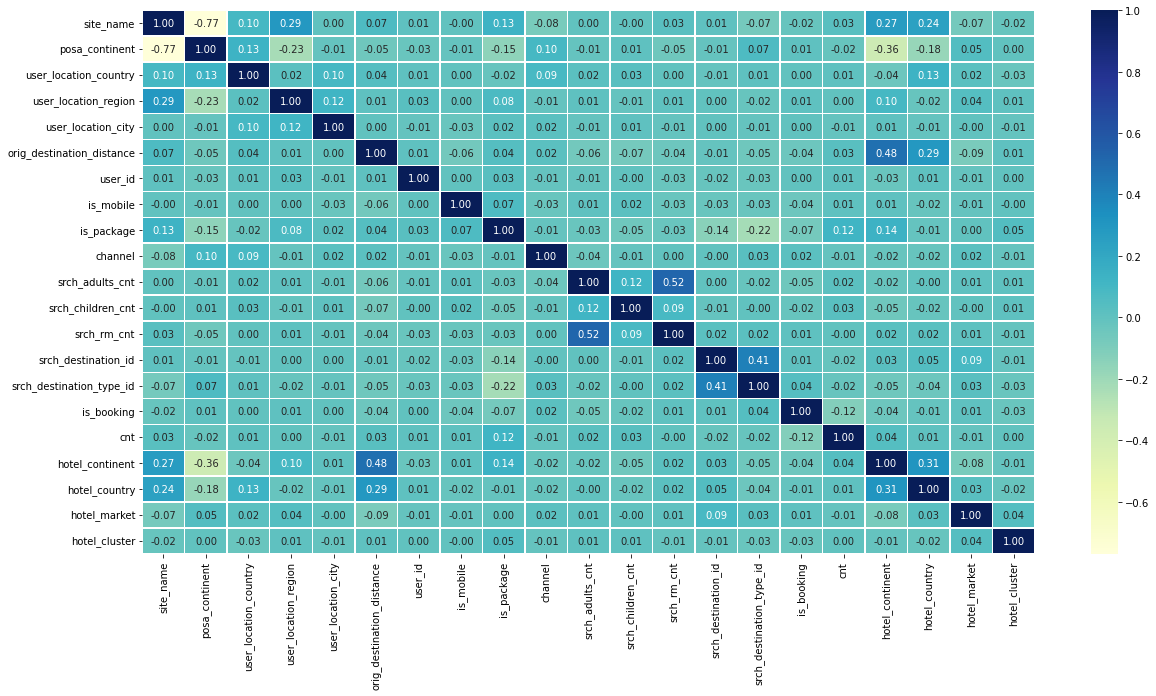

In [31]:
corr = train_data_copy.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(round(corr, 2).iloc[:, :], annot=True, linewidths=.5, ax=ax, cmap="YlGnBu",fmt='.2f')

In [32]:
user_dist_matrix = 1 - corr.T.corr()

### Most number of hotels in the Country

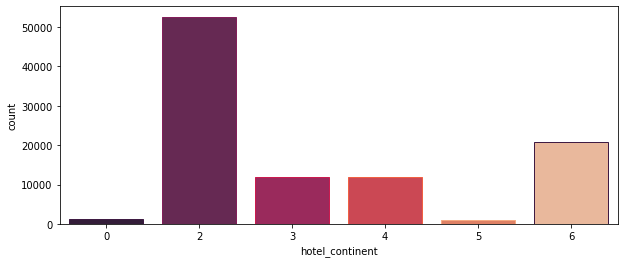

In [35]:
plt.figure(figsize=(10, 4))
sns.countplot(x='hotel_continent', palette='rocket',data=train_data, edgecolor=sns.color_palette("rocket", 5))

### User Location Country

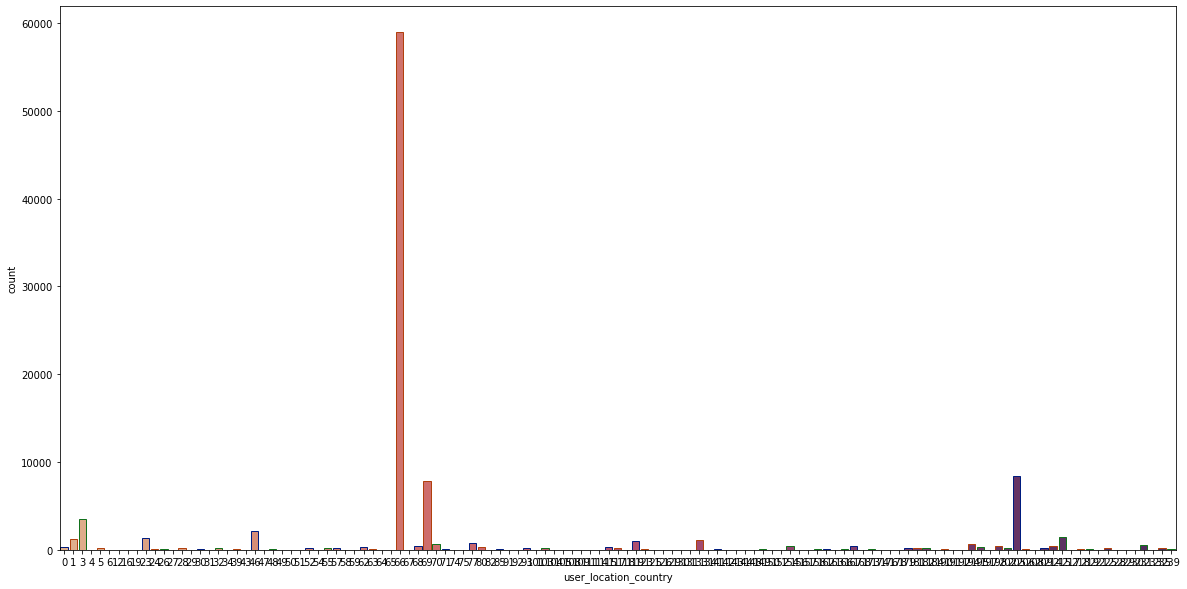

In [37]:
plt.figure(figsize=(20, 10))
sns.countplot(x=train_data['user_location_country'],palette="flare", edgecolor=sns.color_palette("dark", 3))

### Top 10 User Countries

In [38]:
top_ten_user_countries = train_data.groupby('user_location_country')['user_location_region'].count().sort_values(ascending=False)[:10]

In [39]:
top_ten_user_countries

user_location_country
66     58956
205     8363
69      7895
3       3535
46      2195
215     1428
23      1331
1       1185
133     1155
119      969
Name: user_location_region, dtype: int64

### Total Number of Bookings over Date

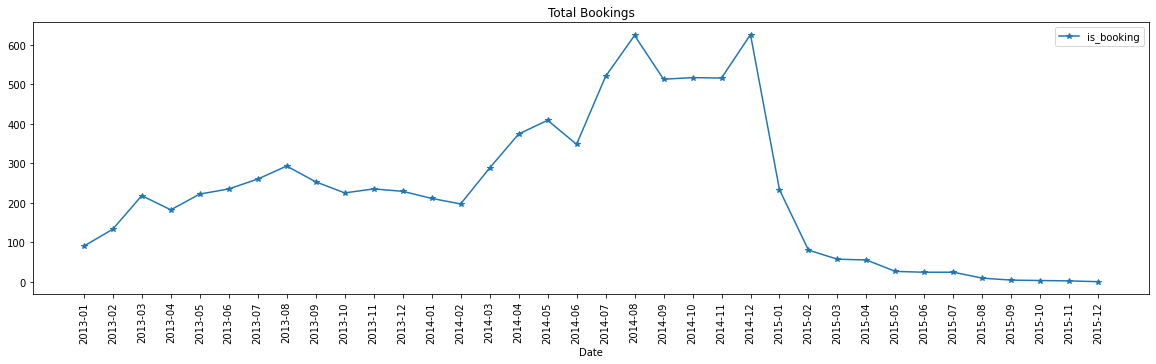

In [40]:
train_data['Date']  = train_data['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)
date_bookings  = train_data.groupby('Date')["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='*',title="Total Bookings", figsize=(20,5)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)

### Creating a new dataframe with user_id, hotel_cluster and is_booking fields

In [41]:
new_df = train_data[['user_id', 'hotel_cluster', 'is_booking']]

In [42]:
new_df.head()

,user_id,hotel_cluster,is_booking
0,12,1,0
1,12,1,1
2,12,1,0
3,776,24,0
4,3313,45,0


In [43]:
new_df.columns = ['user_id', 'hotel_id', 'booking']
new_df = new_df.sort_values(['user_id', 'hotel_id'])
new_df = new_df.reset_index().drop('index', axis = 1)
new_df.head()

,user_id,hotel_id,booking
0,12,1,0
1,12,1,1
2,12,1,0
3,93,21,0
4,93,80,0


In [44]:
booked_hotels = new_df.groupby(['user_id', 'hotel_id']).booking.transform(max)
new_df = new_df.loc[new_df.booking == booked_hotels]
new_df.drop_duplicates(keep = 'first', inplace = True)
new_df= new_df.reset_index().drop('index', axis = 1)
new_df.head()

,user_id,hotel_id,booking
0,12,1,1
1,93,21,0
2,93,80,0
3,93,92,0
4,501,10,0


### Calculated each of the hotel cluster's mean to find similar hotel clusters

In [45]:
bookings = pd.DataFrame(new_df.groupby(['hotel_id'])['booking'].mean())
bookings

,booking
hotel_id,
0,0.117794
1,0.253205
2,0.207469
3,0.113372
4,0.184855
...,...
95,0.230104
96,0.076212
97,0.149474


In [46]:
bookings['number_of_bookings'] = pd.DataFrame(new_df.groupby('hotel_id')['booking'].count())
bookings.head()

,booking,number_of_bookings
hotel_id,,
0,0.117794,399
1,0.253205,312
2,0.207469,482
3,0.113372,344
4,0.184855,449


In [47]:
bookings_matrix = new_df.pivot_table(index = 'user_id', columns = 'hotel_id', values = 'booking')
bookings_matrix.head()

hotel_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
12,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
756,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
bookings_matrix = bookings_matrix.fillna(0)
bookings_matrix

hotel_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
756,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding similar hotel clusters

In [49]:
def find_similar_hotel_clusters(hotel_cluster): 
    item_user_bookings = bookings_matrix[hotel_cluster]
    hotel_correlation = bookings_matrix.corrwith(item_user_bookings)
    corr_clusterid = pd.DataFrame(hotel_correlation, columns=['correlation_value'])
    corr_clusterid.loc[~(corr_clusterid==0).all(axis=1)]
    corr_clusterid = corr_clusterid.round({'correlation_value': 2})
    return corr_clusterid.sort_values('correlation_value',ascending=False).head(n = 5)

In [50]:
find_similar_hotel_clusters(11)

,correlation_value
hotel_id,
11,1.00
82,0.13
33,0.12
20,0.12
64,0.11


#### Value counts of 100 hotel clusters

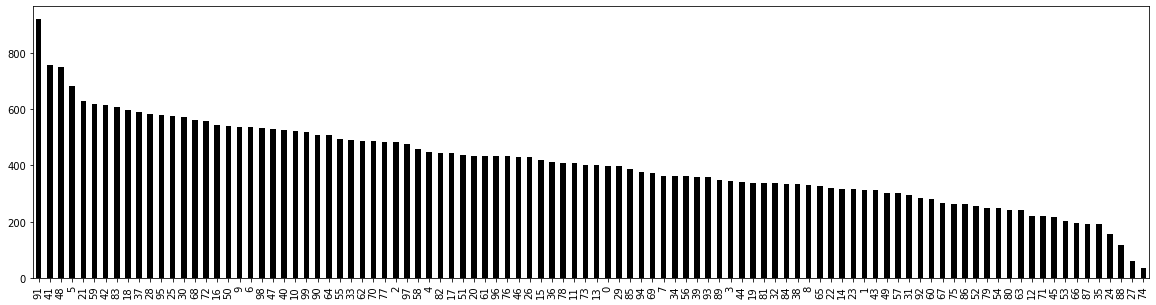

In [51]:
new_df['hotel_id'].value_counts().plot(kind='bar',color="black",figsize=(20,5))

## Collaborative Filtering using Cosine Similarity

In [54]:
users_count, hotels_count = new_df.user_id.unique().shape[0], new_df.hotel_id.unique().shape[0]

In [55]:
print("The no of unique users = ",users_count)
print("The no of hotel clusters = ",hotels_count)

The no of unique users =  3472
The no of hotel clusters =  100


In [56]:
def map_ids_to_idx(df):
    user_idx = np.arange(0, users_count)
    hotel_idx = np.arange(0, hotels_count)
    
    idx_user_df = pd.DataFrame(df.user_id.unique(), columns=["user"])
    idx_user_df["idx"] = user_idx
    
    idx_hotel_df = pd.DataFrame(df.hotel_id.unique(), columns=["hotel"])
    idx_hotel_df["idx"] = hotel_idx
    
    df["hotel_index"] = df["hotel_id"].map(idx_hotel_df.set_index('hotel')["idx"]).fillna(0)
    df["user_index"] = df["user_id"].map(idx_user_df.set_index('user')["idx"]).fillna(0)

    return df

In [57]:
new_df = map_ids_to_idx(new_df)
new_df

,user_id,hotel_id,booking,hotel_index,user_index
0,12,1,1,0,0
1,93,21,0,1,1
2,93,80,0,2,1
3,93,92,0,3,1
4,501,10,0,4,2
...,...,...,...,...,...
40643,391007,81,0,29,3471
40644,391007,85,0,31,3471
40645,391007,90,0,59,3471
40646,391007,93,0,86,3471


### Splitting the data into training and testing

In [52]:
training_data, testing_data = train_test_split(new_df, test_size = 0.3)

In [58]:
utility_matrix = np.zeros((users_count, hotels_count))
for row in new_df.itertuples():
    utility_matrix[row[5], row[4]] = row[3]
utility_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
train_data_copy = train_data_copy.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

### Identifying holidays in some countries and checking if the checkin or checkout date is in holidays

In [60]:
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()

uk_holidays = holidays.UnitedKingdom()
gr_holidays = holidays.Germany()

train_data_copy['north_am_ci'] = train_data_copy['srch_ci'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)
train_data_copy['north_am_co'] = train_data_copy['srch_co'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)

train_data_copy['europe_ci'] = train_data_copy['srch_ci'].apply(lambda x: 1 if x in (uk_holidays or gr_holidays)  else 0)
train_data_copy['europe_co'] = train_data_copy['srch_co'].apply(lambda x: 1 if x in (uk_holidays or gr_holidays)  else 0)

### Extracting month from date_time

In [61]:
# extract month from date_time
train_data_copy['click_month'] = pd.DatetimeIndex(train_data_copy['date_time']).month
train_data_copy['checkin_month'] = pd.DatetimeIndex(train_data_copy['srch_ci']).month
train_data_copy['checkout_month'] = pd.DatetimeIndex(train_data_copy['srch_co']).month

In [62]:
train_data_copy = train_data_copy.drop(['date_time', 'srch_ci', 'srch_co'], axis=1)

In [63]:
data = pd.get_dummies(train_data_copy)
print(data.shape)

(62736, 28)


In [64]:
Y = data['hotel_cluster']
X = data.drop(['hotel_cluster'],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62736 entries, 0 to 99374
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   site_name                  62736 non-null  int64  
 1   posa_continent             62736 non-null  int64  
 2   user_location_country      62736 non-null  int64  
 3   user_location_region       62736 non-null  int64  
 4   user_location_city         62736 non-null  int64  
 5   orig_destination_distance  62736 non-null  float64
 6   user_id                    62736 non-null  int64  
 7   is_mobile                  62736 non-null  int64  
 8   is_package                 62736 non-null  int64  
 9   channel                    62736 non-null  int64  
 10  srch_adults_cnt            62736 non-null  int64  
 11  srch_children_cnt          62736 non-null  int64  
 12  srch_rm_cnt                62736 non-null  int64  
 13  srch_destination_id        62736 non-null  int

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=101)

DeepFM

In [66]:
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62736 entries, 0 to 99374
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   site_name                  62736 non-null  int64  
 1   posa_continent             62736 non-null  int64  
 2   user_location_country      62736 non-null  int64  
 3   user_location_region       62736 non-null  int64  
 4   user_location_city         62736 non-null  int64  
 5   orig_destination_distance  62736 non-null  float64
 6   user_id                    62736 non-null  int64  
 7   is_mobile                  62736 non-null  int64  
 8   is_package                 62736 non-null  int64  
 9   channel                    62736 non-null  int64  
 10  srch_adults_cnt            62736 non-null  int64  
 11  srch_children_cnt          62736 non-null  int64  
 12  srch_rm_cnt                62736 non-null  int64  
 13  srch_destination_id        62736 non-null  int

In [ ]:
train_data_copy = train_data_copy.rename(columns={'hotel_cluster': 'item_id', 'is_booking': 'rating'})

In [ ]:
sparse_features = ['site_name','posa_continent','user_location_country','user_location_region','user_location_city',
             'user_id','is_mobile','is_package','channel','click_month','checkin_month','checkout_month',
            'srch_adults_cnt','srch_children_cnt','srch_rm_cnt','srch_destination_id','hotel_continent',
               'hotel_country','cnt','north_am_ci', 'north_am_co', 'europe_ci', 'europe_co','click_month',
                   'checkin_month','checkout_month']

dense_features = ['hotel_market']
target = ['rating']

### Sparse features Label Encoding and Dense numerical features normalization

In [ ]:
for feat in sparse_features:
    lbe = LabelEncoder()
    train_data_copy[feat] = lbe.fit_transform(train_data_copy[feat])

In [ ]:
mms = MinMaxScaler(feature_range=(0,1))
train_data_copy[dense_features] = mms.fit_transform(train_data_copy[dense_features])

In [ ]:
from deepctr.feature_column import SparseFeat,get_feature_names
# count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, train_data_copy[feat].nunique(),embedding_dim=4)
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
train, test = train_test_split(train_data_copy, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [ ]:
model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 5s - loss: 0.2965 - binary_crossentropy: 0.2964 - val_loss: 0.2532 - val_binary_crossentropy: 0.2529
Epoch 2/10
40334/40334 - 2s - loss: 0.2247 - binary_crossentropy: 0.2243 - val_loss: 0.2668 - val_binary_crossentropy: 0.2662
Epoch 3/10
40334/40334 - 2s - loss: 0.2075 - binary_crossentropy: 0.2068 - val_loss: 0.2899 - val_binary_crossentropy: 0.2890
Epoch 4/10
40334/40334 - 2s - loss: 0.1984 - binary_crossentropy: 0.1975 - val_loss: 0.3019 - val_binary_crossentropy: 0.3008
Epoch 5/10
40334/40334 - 2s - loss: 0.1922 - binary_crossentropy: 0.1911 - val_loss: 0.3204 - val_binary_crossentropy: 0.3192
Epoch 6/10
40334/40334 - 2s - loss: 0.1876 - binary_crossentropy: 0.1862 - val_loss: 0.3485 - val_binary_crossentropy: 0.3471
Epoch 7/10
40334/40334 - 2s - loss: 0.1845 - binary_crossentropy: 0.1830 - val_loss: 0.3584 - val_bi

In [ ]:
#model prediction
pred_result = model.predict(test_model_input, batch_size=256)

In [ ]:

auc = roc_auc_score(test[target].values, pred_result)

print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),"MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_result),2),"AUC:\t%f" % np.round(auc,2),sep='\n')

RMSE:	0.300000
MAE:	0.140000
MSE:	0.090000
AUC:	0.700000


### Tuning Hyperparameters

In [ ]:
param_grid = {'dnn_hidden_units' : [(1,1),(2,2),(4,4),(27,27),(128,128),(256,256)],
              'dnn_use_bn':[True,False],
              'l2_reg_linear':[1e-5,1e-3,1e-1,1,10],
              'l2_reg_embedding':[1e-7,1e-5,1e-3,1e-1,1],
              'l2_reg_dnn':[0,0.2,2,4],
              'dnn_dropout':[0, 0.1, 0.3, 0.7, 0.9,0.11]
             }
result = {}

### dnn_hidden_units – list,list of positive integer or empty list, the layer number and units in each layer of DNN

In [ ]:
dnn_hidden_units_layer = {}
for x in param_grid['dnn_hidden_units']:
    model = DeepFM(linear_feature_columns,dnn_feature_columns,fm_group=['default_group'], dnn_hidden_units=x, 
              seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    dnn_hidden_units_layer[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
result['dnn_hidden_units']=dnn_hidden_units_layer

Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 8s - loss: 0.1107 - mean_squared_error: 0.1107 - val_loss: 0.0800 - val_mean_squared_error: 0.0799
Epoch 2/10
40334/40334 - 3s - loss: 0.0758 - mean_squared_error: 0.0756 - val_loss: 0.0749 - val_mean_squared_error: 0.0745
Epoch 3/10
40334/40334 - 2s - loss: 0.0712 - mean_squared_error: 0.0706 - val_loss: 0.0744 - val_mean_squared_error: 0.0737
Epoch 4/10
40334/40334 - 3s - loss: 0.0687 - mean_squared_error: 0.0678 - val_loss: 0.0752 - val_mean_squared_error: 0.0741
Epoch 5/10
40334/40334 - 2s - loss: 0.0669 - mean_squared_error: 0.0657 - val_loss: 0.0758 - val_mean_squared_error: 0.0744
Epoch 6/10
40334/40334 - 1s - loss: 0.0656 - mean_squared_error: 0.0641 - val_loss: 0.0773 - val_mean_squared_error: 0.0756
Epoch 7/10
40334/40334 - 1s - loss: 0.0647 - mean_squared_error: 0.0629 - val_loss: 0.0779 - val_mean_squared_error: 0.0760
Epoch 8/10
40334/40334 - 1s - loss: 0.0638 - mean_squared_error: 0.0618 - val_loss

In [ ]:
dnn_hidden_units_layer

{(1, 1): {'AUC': 0.77, 'MAE': 0.16, 'MSE': 0.08, 'RMSE': 0.28},
 (2, 2): {'AUC': 0.77, 'MAE': 0.15, 'MSE': 0.08, 'RMSE': 0.28},
 (4, 4): {'AUC': 0.75, 'MAE': 0.15, 'MSE': 0.09, 'RMSE': 0.3},
 (27, 27): {'AUC': 0.74, 'MAE': 0.13, 'MSE': 0.09, 'RMSE': 0.29},
 (128, 128): {'AUC': 0.75, 'MAE': 0.14, 'MSE': 0.09, 'RMSE': 0.29},
 (256, 256): {'AUC': 0.74, 'MAE': 0.14, 'MSE': 0.09, 'RMSE': 0.3}}

In [ ]:
dnn_hidden_units_layer[(4,4)]

{'AUC': 0.75, 'MAE': 0.15, 'MSE': 0.09, 'RMSE': 0.3}

### dnn_use_bn – bool. Whether use BatchNormalization before activation or not in DNN

In [ ]:
dnn_use_bn_dict = {}
for x in param_grid['dnn_use_bn']:
    model= DeepFM(linear_feature_columns,dnn_feature_columns,fm_group=['default_group'],dnn_hidden_units=(4,4), 
              seed=1024,task='binary',dnn_use_bn=x)

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    dnn_use_bn_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,3)}
result['dnn_use_bn_dict']=dnn_use_bn_dict

Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 6s - loss: 0.1097 - mean_squared_error: 0.1097 - val_loss: 0.0819 - val_mean_squared_error: 0.0818
Epoch 2/10
40334/40334 - 2s - loss: 0.0742 - mean_squared_error: 0.0741 - val_loss: 0.0790 - val_mean_squared_error: 0.0789
Epoch 3/10
40334/40334 - 2s - loss: 0.0701 - mean_squared_error: 0.0700 - val_loss: 0.0766 - val_mean_squared_error: 0.0764
Epoch 4/10
40334/40334 - 2s - loss: 0.0669 - mean_squared_error: 0.0667 - val_loss: 0.0762 - val_mean_squared_error: 0.0760
Epoch 5/10
40334/40334 - 2s - loss: 0.0643 - mean_squared_error: 0.0641 - val_loss: 0.0822 - val_mean_squared_error: 0.0819
Epoch 6/10
40334/40334 - 2s - loss: 0.0620 - mean_squared_error: 0.0617 - val_loss: 0.0808 - val_mean_squared_error: 0.0805
Epoch 7/10
40334/40334 - 2s - loss: 0.0604 - mean_squared_error: 0.0600 - val_loss: 0.0853 - val_mean_squared_error: 0.0849
Epoch 8/10
40334/40334 - 2s - loss: 0.0589 - mean_squared_error: 0.0585 - val_loss

In [ ]:
dnn_use_bn_dict

{False: {'AUC': 0.753, 'MAE': 0.15, 'MSE': 0.09, 'RMSE': 0.29},
 True: {'AUC': 0.733, 'MAE': 0.17, 'MSE': 0.09, 'RMSE': 0.3}}

In [ ]:
dnn_use_bn_dict[False]

{'AUC': 0.753, 'MAE': 0.15, 'MSE': 0.09, 'RMSE': 0.29}

### l2_reg_linear – float. L2 regularizer strength applied to linear part

In [ ]:

l2_reg_linear_dict={}
for x in param_grid['l2_reg_linear']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4), l2_reg_linear=x,
            fm_group=['default_group'], dnn_use_bn=False,
                   seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    
    l2_reg_linear_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
    
result['l2_reg_linear']=l2_reg_linear_dict

Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 6s - loss: 0.0989 - mean_squared_error: 0.0988 - val_loss: 0.0783 - val_mean_squared_error: 0.0782
Epoch 2/10
40334/40334 - 2s - loss: 0.0752 - mean_squared_error: 0.0750 - val_loss: 0.0748 - val_mean_squared_error: 0.0744
Epoch 3/10
40334/40334 - 2s - loss: 0.0699 - mean_squared_error: 0.0694 - val_loss: 0.0743 - val_mean_squared_error: 0.0737
Epoch 4/10
40334/40334 - 2s - loss: 0.0661 - mean_squared_error: 0.0653 - val_loss: 0.0764 - val_mean_squared_error: 0.0754
Epoch 5/10
40334/40334 - 2s - loss: 0.0634 - mean_squared_error: 0.0623 - val_loss: 0.0784 - val_mean_squared_error: 0.0772
Epoch 6/10
40334/40334 - 2s - loss: 0.0613 - mean_squared_error: 0.0600 - val_loss: 0.0811 - val_mean_squared_error: 0.0798
Epoch 7/10
40334/40334 - 2s - loss: 0.0597 - mean_squared_error: 0.0584 - val_loss: 0.0852 - val_mean_squared_error: 0.0838
Epoch 8/10
40334/40334 - 2s - loss: 0.0586 - mean_squared_error: 0.0572 - val_loss

In [ ]:
l2_reg_linear_dict

{1e-05: {'AUC': 0.75, 'MAE': 0.15, 'MSE': 0.09, 'RMSE': 0.29},
 0.001: {'AUC': 0.75, 'MAE': 0.15, 'MSE': 0.09, 'RMSE': 0.29},
 0.1: {'AUC': 0.75, 'MAE': 0.15, 'MSE': 0.08, 'RMSE': 0.29},
 1: {'AUC': 0.75, 'MAE': 0.14, 'MSE': 0.08, 'RMSE': 0.29},
 10: {'AUC': 0.76, 'MAE': 0.14, 'MSE': 0.08, 'RMSE': 0.29}}

In [ ]:
l2_reg_linear_dict[1e-05]

{'AUC': 0.75, 'MAE': 0.15, 'MSE': 0.09, 'RMSE': 0.29}

### l2_reg_embedding – float. L2 regularizer strength applied to embedding vector

In [ ]:
l2_reg_embedding_layer={}
for x in param_grid['l2_reg_embedding']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4), l2_reg_linear=1e-05,l2_reg_embedding=x, seed=1024, task='binary',
               dnn_use_bn=False,fm_group=['default_group'])

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    l2_reg_embedding_layer[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
result['l2_reg_embedding']=l2_reg_embedding_layer

Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 8s - loss: 0.0984 - mean_squared_error: 0.0984 - val_loss: 0.0783 - val_mean_squared_error: 0.0783
Epoch 2/10
40334/40334 - 2s - loss: 0.0757 - mean_squared_error: 0.0756 - val_loss: 0.0750 - val_mean_squared_error: 0.0750
Epoch 3/10
40334/40334 - 2s - loss: 0.0691 - mean_squared_error: 0.0690 - val_loss: 0.0742 - val_mean_squared_error: 0.0741
Epoch 4/10
40334/40334 - 2s - loss: 0.0641 - mean_squared_error: 0.0640 - val_loss: 0.0762 - val_mean_squared_error: 0.0761
Epoch 5/10
40334/40334 - 2s - loss: 0.0609 - mean_squared_error: 0.0608 - val_loss: 0.0800 - val_mean_squared_error: 0.0799
Epoch 6/10
40334/40334 - 2s - loss: 0.0587 - mean_squared_error: 0.0586 - val_loss: 0.0819 - val_mean_squared_error: 0.0818
Epoch 7/10
40334/40334 - 2s - loss: 0.0572 - mean_squared_error: 0.0571 - val_loss: 0.0845 - val_mean_squared_error: 0.0844
Epoch 8/10
40334/40334 - 2s - loss: 0.0559 - mean_squared_error: 0.0558 - val_loss

In [ ]:
l2_reg_embedding_layer

{1e-07: {'AUC': 0.73, 'MAE': 0.14, 'MSE': 0.09, 'RMSE': 0.29},
 1e-05: {'AUC': 0.75, 'MAE': 0.16, 'MSE': 0.09, 'RMSE': 0.3},
 0.001: {'AUC': 0.78, 'MAE': 0.15, 'MSE': 0.07, 'RMSE': 0.27},
 0.1: {'AUC': 0.77, 'MAE': 0.17, 'MSE': 0.07, 'RMSE': 0.27},
 1: {'AUC': 0.76, 'MAE': 0.17, 'MSE': 0.07, 'RMSE': 0.27}}

In [ ]:
l2_reg_embedding_layer[.001]

{'AUC': 0.78, 'MAE': 0.15, 'MSE': 0.07, 'RMSE': 0.27}

### l2_reg_dnn: float. L2 regularizer strength applied to DNN

In [ ]:
l2_reg_dnn_dict={}
for x in param_grid['l2_reg_dnn']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4, 4), l2_reg_linear=1e-05,
            l2_reg_embedding=0.001, l2_reg_dnn=x, seed=1024,task='binary',dnn_use_bn=False,fm_group=['default_group'])

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    
    l2_reg_dnn_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
result['l2_reg_dnn']=l2_reg_dnn_dict

Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 11s - loss: 0.0998 - mean_squared_error: 0.0988 - val_loss: 0.0796 - val_mean_squared_error: 0.0787
Epoch 2/10
40334/40334 - 3s - loss: 0.0779 - mean_squared_error: 0.0769 - val_loss: 0.0777 - val_mean_squared_error: 0.0765
Epoch 3/10
40334/40334 - 3s - loss: 0.0759 - mean_squared_error: 0.0744 - val_loss: 0.0763 - val_mean_squared_error: 0.0748
Epoch 4/10
40334/40334 - 3s - loss: 0.0747 - mean_squared_error: 0.0730 - val_loss: 0.0760 - val_mean_squared_error: 0.0743
Epoch 5/10
40334/40334 - 3s - loss: 0.0739 - mean_squared_error: 0.0721 - val_loss: 0.0755 - val_mean_squared_error: 0.0738
Epoch 6/10
40334/40334 - 3s - loss: 0.0732 - mean_squared_error: 0.0713 - val_loss: 0.0755 - val_mean_squared_error: 0.0735
Epoch 7/10
40334/40334 - 3s - loss: 0.0727 - mean_squared_error: 0.0706 - val_loss: 0.0753 - val_mean_squared_error: 0.0733
Epoch 8/10
40334/40334 - 3s - loss: 0.0722 - mean_squared_error: 0.0700 - val_los

In [ ]:
l2_reg_dnn_dict

{0: {'AUC': 0.78, 'MAE': 0.15, 'MSE': 0.07, 'RMSE': 0.27},
 0.2: {'AUC': 0.77, 'MAE': 0.16, 'MSE': 0.07, 'RMSE': 0.27},
 2: {'AUC': 0.77, 'MAE': 0.16, 'MSE': 0.07, 'RMSE': 0.27},
 4: {'AUC': 0.77, 'MAE': 0.16, 'MSE': 0.07, 'RMSE': 0.27}}

In [ ]:
l2_reg_dnn_dict[0]

{'AUC': 0.78, 'MAE': 0.15, 'MSE': 0.07, 'RMSE': 0.27}

### dnn_dropout – float in [0,1), the probability we will drop out a given DNN coordinate.

In [ ]:
dnn_dropout_dict={}
for x in param_grid['dnn_dropout']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4),seed=1024, dnn_dropout=x, dnn_activation='relu',task='binary',
                   fm_group=['default_group'],dnn_use_bn=False)

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    
    dnn_dropout_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,3)}
result['dnn_dropout']=dnn_dropout_dict

Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 16s - loss: 0.0992 - mean_squared_error: 0.0991 - val_loss: 0.0784 - val_mean_squared_error: 0.0783
Epoch 2/10
40334/40334 - 3s - loss: 0.0760 - mean_squared_error: 0.0758 - val_loss: 0.0754 - val_mean_squared_error: 0.0751
Epoch 3/10
40334/40334 - 3s - loss: 0.0707 - mean_squared_error: 0.0702 - val_loss: 0.0741 - val_mean_squared_error: 0.0735
Epoch 4/10
40334/40334 - 3s - loss: 0.0667 - mean_squared_error: 0.0659 - val_loss: 0.0753 - val_mean_squared_error: 0.0743
Epoch 5/10
40334/40334 - 3s - loss: 0.0639 - mean_squared_error: 0.0628 - val_loss: 0.0777 - val_mean_squared_error: 0.0764
Epoch 6/10
40334/40334 - 5s - loss: 0.0619 - mean_squared_error: 0.0606 - val_loss: 0.0806 - val_mean_squared_error: 0.0792
Epoch 7/10
40334/40334 - 5s - loss: 0.0603 - mean_squared_error: 0.0589 - val_loss: 0.0820 - val_mean_squared_error: 0.0805
Epoch 8/10
40334/40334 - 4s - loss: 0.0590 - mean_squared_error: 0.0575 - val_los

In [ ]:
dnn_dropout_dict

{0: {'AUC': 0.753, 'MAE': 0.14, 'MSE': 0.08, 'RMSE': 0.29},
 0.1: {'AUC': 0.761, 'MAE': 0.15, 'MSE': 0.08, 'RMSE': 0.28},
 0.11: {'AUC': 0.754, 'MAE': 0.13, 'MSE': 0.08, 'RMSE': 0.28},
 0.3: {'AUC': 0.755, 'MAE': 0.14, 'MSE': 0.08, 'RMSE': 0.28},
 0.7: {'AUC': 0.769, 'MAE': 0.15, 'MSE': 0.08, 'RMSE': 0.28},
 0.9: {'AUC': 0.769, 'MAE': 0.16, 'MSE': 0.08, 'RMSE': 0.28}}

In [ ]:
dnn_dropout_dict[.7]

{'AUC': 0.769, 'MAE': 0.15, 'MSE': 0.08, 'RMSE': 0.28}

### Final model after Hyperparameter tuning

In [ ]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4)
            ,  l2_reg_linear=1e-05, l2_reg_embedding=0.001,seed=1024, dnn_dropout=0.7, dnn_activation='relu',task='binary',
               fm_group=['default_group'],l2_reg_dnn=0, dnn_use_bn=False)

model.compile("adam", "mse", metrics=['mse'])

In [ ]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Train on 40334 samples, validate on 10084 samples
Epoch 1/10
40334/40334 - 14s - loss: 0.1089 - mean_squared_error: 0.1086 - val_loss: 0.0798 - val_mean_squared_error: 0.0795
Epoch 2/10
40334/40334 - 3s - loss: 0.0788 - mean_squared_error: 0.0784 - val_loss: 0.0784 - val_mean_squared_error: 0.0779
Epoch 3/10
40334/40334 - 3s - loss: 0.0767 - mean_squared_error: 0.0759 - val_loss: 0.0769 - val_mean_squared_error: 0.0759
Epoch 4/10
40334/40334 - 4s - loss: 0.0753 - mean_squared_error: 0.0742 - val_loss: 0.0761 - val_mean_squared_error: 0.0749
Epoch 5/10
40334/40334 - 3s - loss: 0.0744 - mean_squared_error: 0.0731 - val_loss: 0.0757 - val_mean_squared_error: 0.0745
Epoch 6/10
40334/40334 - 3s - loss: 0.0738 - mean_squared_error: 0.0725 - val_loss: 0.0754 - val_mean_squared_error: 0.0741
Epoch 7/10
40334/40334 - 3s - loss: 0.0731 - mean_squared_error: 0.0718 - val_loss: 0.0754 - val_mean_squared_error: 0.0740
Epoch 8/10
40334/40334 - 3s - loss: 0.0727 - mean_squared_error: 0.0712 - val_los

In [ ]:
pred_result = model.predict(test_model_input, batch_size=256)
    
auc = roc_auc_score(test[target].values, pred_result)

In [ ]:
print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),"MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_result),2),"AUC score:\t%f" % np.round(auc,2), sep='\n')

RMSE:	0.270000
MAE:	0.160000
MSE:	0.070000
AUC score:	0.770000


### Recommend Hotel for a user

In [ ]:
rows = []
hotel = list(train_data_copy.drop_duplicates(subset='item_id', keep='first').item_id)
names = list(train_data_copy.drop_duplicates(subset='item_id', keep='first').item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'item_id' : hotel[i], 'user_id' : 1048}))
test_data = pd.DataFrame(rows)

In [ ]:
for idx, (score, name) in enumerate(sorted(zip(pred_result, names), reverse=True)):
    if idx >= 5:
        break
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  0.36  for hotel cluster:  19
Score:  0.31  for hotel cluster:  45
Score:  0.3  for hotel cluster:  24
Score:  0.26  for hotel cluster:  11
Score:  0.2  for hotel cluster:  23
